In [1]:
import numpy as np
import sys,glob,os,time
import vaex
import seaborn as sea 
import math 

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
import matplotlib.patheffects as path_effects

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# not really necessary
sea.set(font_scale=3,palette=sea.color_palette('colorblind'), 
        rc={'axes.facecolor':'white'},font='Helvetica',color_codes=False)
sea.set_style(style="ticks",rc={"xtick.direction": "in","ytick.direction": "in",
                                "xtick.minor.size": 4, "ytick.minor.size": 4})


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


pi = math.pi

%config IPCompleter.use_jedi = False 

In [2]:
gaia_path = '/data/koppelman/datasets/gaia/gaia-edr3'
df = vaex.open(f'{gaia_path}/gaia-edr3-rv-sort-by-source_id.hdf5')

In [3]:
vlsr = 229 # Eilers+2019
U=11.1   # Schoenrich+2010
V=12.24  # Schoenrich+2010
W=7.25   # Schoenrich+2010
Rsun = 8.122 # GravityCollaboration+2018

vx_sun = U
vy_sun = V+vlsr
vz_sun = W

In [4]:
zpt = 0.017
df['distance'] = 1/(df.parallax + zpt)
df.add_virtual_columns_spherical_to_cartesian('l', 'b', 'distance')
df.add_virtual_columns_proper_motion_eq2gal('ra', 'dec', 'pmra', 'pmdec')
df.add_virtual_columns_lbrvr_proper_motion2vcartesian('l', 'b', 'distance', vr=df.dr2_radial_velocity.expression)


df.add_variable('vlsr',vlsr)
df.add_variable('R0',Rsun)
df.add_variable('_U',U)
df.add_variable('_V',V)
df.add_variable('_W',W)



# Correct the Cartesian velocities for the motion of the Sun and the LSR
df.add_virtual_column('vx_apex','vx+_U')
df.add_virtual_column('vy_apex','vy+_V+vlsr')
df.add_virtual_column('vz_apex','vz+_W')


df['Lx'] = df.y*df.vz_apex - df.z*df.vy_apex
df['Ly'] = df.z*df.vx_apex - (df.x-df['R0'])*df.vz_apex
df['Lz'] = -((df.x-df['R0'])*df.vy_apex - df.y*df.vx_apex)

### NEW TOOMRE CUT
df.add_virtual_columns_cartesian_to_polar(x='(x-R0)', radius_out='R', azimuth_out='rPhi',radians=True)
df.add_virtual_columns_cartesian_velocities_to_polar(x='(x-R0)', vx='vx_apex', vy='vy_apex',
                                                     vr_out='vR', vazimuth_out='vphi')  
df['vphi'] = -df.vphi.values


# position depending correction for the LSR
df['_vx'] = df.vx+11.1-df['vlsr']*df.rPhi.sin()
df['_vy'] = df.vy+12.24-df['vlsr']*df.rPhi.cos()
df['_vz'] = df.vz+7.25



# The selection
df.select('(_vx**2 + (_vy-232)**2 + _vz**2) > 210**2', name='halo')
df.select('(_vx**2 + (_vy-232)**2 + _vz**2) < 50**2', name='thin')
# df.select('(~thin) & ((_vx**2 + (_vy-232)**2 + _vz**2) < 210**2)', name='thick')
df.select('((_vx**2 + (_vy-232)**2 + _vz**2) > 210**2) & ((_vx**2 + (_vy-232)**2 + _vz**2) < 230**2)', name='thick')



df.add_virtual_column('vtoomre','sqrt(_vx**2 + (_vy-232)**2 + _vz**2)')

df.select('(parallax_over_error>5)&(ruwe<1.4)', name='quality')

In [5]:
mean_vR, mean_vphi, mean_vz = df.mean(['vR','vphi','vz_apex'], selection='(quality)')


print(mean_vR, mean_vphi, mean_vz)

0.45504686703112296 210.83976551386272 -0.6101459530135516


In [6]:
# These are mean values taken from Gaia EDR3
mean_vR, mean_vphi, mean_vz = 0.45504686703112296, 210.83976551386272, -0.6101459530135516

# Galactocentric
df['phi'] = (df.y/(df.x-Rsun)).arctan() # x, y are wrt the Sun
df['vx_gc_bulk'] = mean_vR * (df.phi).cos() - mean_vphi * (df.phi).sin()
df['vy_gc_bulk'] = mean_vR * (df.phi).sin() + mean_vphi * (df.phi).cos()
df['vz_gc_bulk'] = mean_vz * (df['l/l'].values) # l/l is just to create an array of ones


# Heliocentric
df['vx_hc_bulk'] = df.vx_gc_bulk - vx_sun
df['vy_hc_bulk'] = df.vy_gc_bulk - vy_sun
df['vz_hc_bulk'] = df.vz_gc_bulk - vz_sun


# x, y, z and distance are wrt the Sun
df['mean_vlos_bulk'] = (df.x*df.vx_hc_bulk+df.y*df.vy_hc_bulk+df.z*df.vz_hc_bulk)/df.distance

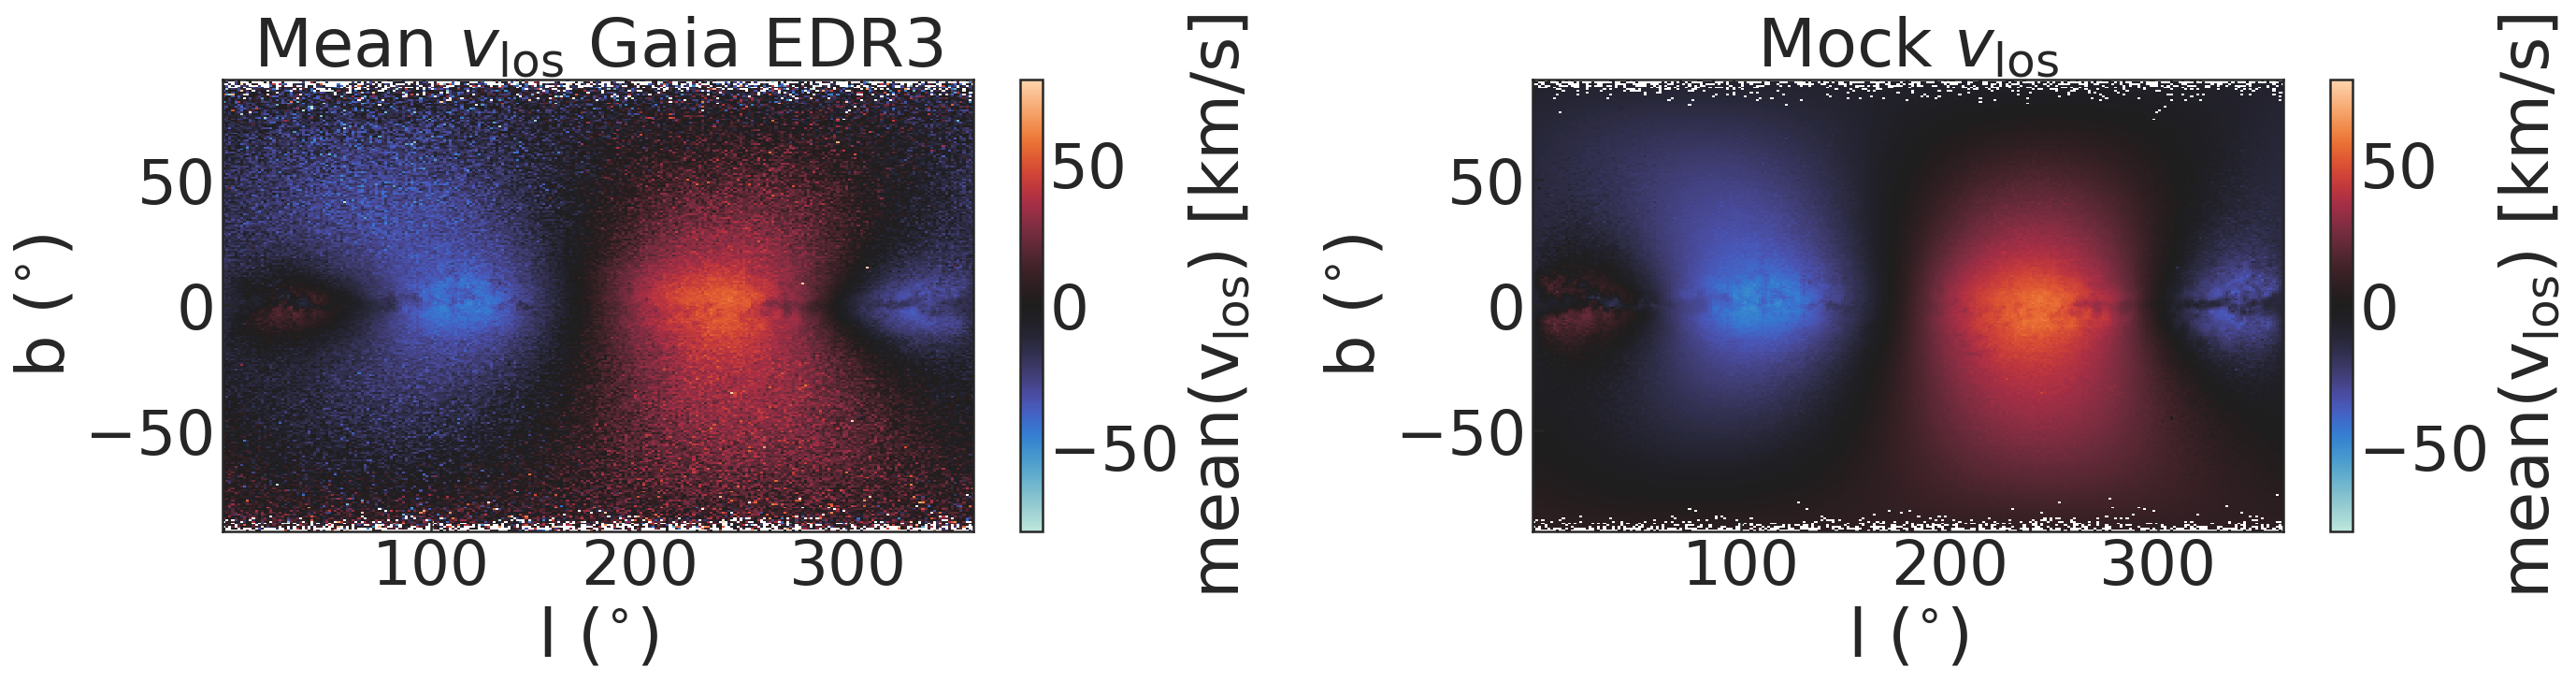

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

plt.sca(axes[0])
plt.title(r'Mean $v_{\rm los}$ Gaia EDR3')
df.plot('l','b',what='mean(dr2_radial_velocity)', colorbar_label=r'mean(v$_{\rm los}$) [km/s]', colormap='icefire', vmin=-80, vmax=80, selection='(quality)')
plt.sca(axes[1])
plt.title(r'Mock $v_{\rm los}$')
df.plot('l','b',what='mean(mean_vlos_bulk)', colorbar_label=r'mean(v$_{\rm los}$) [km/s]', colormap='icefire', vmin=-80, vmax=80, selection='(quality)')
plt.savefig('mean-vlos-on-sky.png',dpi=150, pad_inches=0.02,bbox_inches='tight', transparent=False)